In [1]:
#| code-fold: true
!pip install -Uqq fastbook nbdev torch
import fastbook
fastbook.setup_book()

from fastai.vision.all import *
from fastbook import *
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

matplotlib.rc('image', cmap='Greys')

## Get the data

First thing to do: we'll download the MNIST dataset for us to use as our example.

In [2]:
path = untar_data(URLs.MNIST_SAMPLE)

In [3]:
# what does this do?
Path.BASE_PATH = path

In [4]:
path.ls()

(#3) [Path('valid'),Path('labels.csv'),Path('train')]

In [5]:
# see what's inside the training folder
(path / 'train').ls()

(#2) [Path('train/7'),Path('train/3')]

3 and 7 are the labels or targets of our dataset. We are trying to predict whether, given a particular image, we are looking at a 3 or a 7.

In [6]:
threes = (path / 'train'/'3').ls().sorted()
sevens = (path / 'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [7]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

Now we're getting a slice of the image to see how it is represented underneath as numbers.

The first index value is the rows we want, and then we get the columns.

In [8]:
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [9]:
array(im3)[4:10,4:15]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29, 150, 195, 254, 255, 254],
       [  0,   0,   0,  48, 166, 224, 253, 253, 234, 196, 253],
       [  0,  93, 244, 249, 253, 187,  46,  10,   8,   4,  10],
       [  0, 107, 253, 253, 230,  48,   0,   0,   0,   0,   0],
       [  0,   3,  20,  20,  15,   0,   0,   0,   0,   0,  43]], dtype=uint8)

We can also have the same as a tensor. This is a PyTorch object which will allow us to get the benefits of everything PyTorch has to offer (plus speed optimisation if we use a GPU).

In [10]:
tensor(im3)[4:10,4:15]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29, 150, 195, 254, 255, 254],
        [  0,   0,   0,  48, 166, 224, 253, 253, 234, 196, 253],
        [  0,  93, 244, 249, 253, 187,  46,  10,   8,   4,  10],
        [  0, 107, 253, 253, 230,  48,   0,   0,   0,   0,   0],
        [  0,   3,  20,  20,  15,   0,   0,   0,   0,   0,  43]], dtype=torch.uint8)

It basically looks the same except for the name of the object at this moment.

If we plot out the values of a different slice we can visualise how the numbers are used to output the actual image.

In [11]:
im3_tensor = tensor(im3)
df = pd.DataFrame(im3_tensor[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


Note that the rest of this is 28x28 pixels for the whole image, and each pixel can contain values from 0 to 255 to represent all the shades from white to black.

## APPROACH 1: PIXEL SIMILARITY

1. Find the average pixel value for each pixel of the 3s and 7s
2. Use this 'ideal' 3 and 7 to compare a single image that we want to know whether it's a 3 or a 7

In [12]:
three_tensors = [tensor(Image.open(img)) for img in threes]
seven_tensors = [tensor(Image.open(img)) for img in sevens]
len(three_tensors), len(seven_tensors)

(6131, 6265)

We can view these images with the fastai `show_image` function. This takes a tensor and makes it viewable in a Jupyter Notebook:

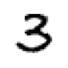

In [13]:
show_image(three_tensors[8]);

In [14]:
torch.stack(three_tensors)[0][4:15, 4:15]

tensor([[  0,   0,   0,   0,   0,   0,   0,  42, 118, 219, 166],
        [  0,   0,   0,   0,   0,   0, 103, 242, 254, 254, 254],
        [  0,   0,   0,   0,   0,   0,  18, 232, 254, 254, 254],
        [  0,   0,   0,   0,   0,   0,   0, 104, 244, 254, 224],
        [  0,   0,   0,   0,   0,   0,   0,   0, 207, 254, 210],
        [  0,   0,   0,   0,   0,   0,   0,   0,  84, 206, 254],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,  24, 209],
        [  0,   0,   0,   0,   0,   0,   0,   0,  91, 137, 253],
        [  0,   0,   0,   0,   0,   0,  40, 214, 250, 254, 254],
        [  0,   0,   0,   0,   0,   0,  81, 247, 254, 254, 254],
        [  0,   0,   0,   0,   0,   0,   0, 110, 246, 254, 254]], dtype=torch.uint8)

It's fairly common to have to convert a collection (i.e. in our case, a list) of tensors into a single tensor object with an extra dimension, so that's why we have the `torch.stack` method which takes a collection and returns a rank-3 tensor.

:::{.callout-tip}

You'll see here that we also convert our values into floats and normalise them (i.e. divide by 255) since this will help us at a later stage.

:::

In [15]:
stacked_threes = torch.stack(three_tensors).float()/255
stacked_sevens = torch.stack(seven_tensors).float()/255

We can see that the first axis of this tensor is our 6131 images, and each image has 28x28 pixels. The `shape` tells you the length of each axis.

In [16]:
stacked_threes.shape

torch.Size([6131, 28, 28])

Note: the *length* of a tensor's shape is its *rank*. We have a rank-3 tensor:

In [17]:
len(stacked_threes.shape)

3

In [18]:
# you can get the same value by using `ndim`
stacked_threes.ndim

3

- Rank = the number of axes in a tensor.
- Shape = the size of each axis of a tensor.

### Getting the ideal 3

We take our stack of threes (i.e. a rank-3 tensor) and we calculate the mean across the first dimension (i.e. the 6131 individual threes).

By the end, you can see that `mean3` is actually a 28x28 tensor (i.e. a single image) that represents the ideal version of our threes data.

In [19]:
mean3 = stacked_threes.mean(0)

In [20]:
mean3.shape

torch.Size([28, 28])

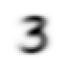

In [21]:
show_image(mean3);

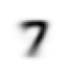

In [22]:
# repeat calculations for 7s
mean7 = stacked_sevens.mean(0)
show_image(mean7);

### Comparing our ideal numbers with an individual sample

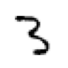

In [23]:
sample_3 = stacked_threes[35]
sample_7 = stacked_sevens[35]
show_image(sample_3);

There are two main ways we can measure the distance (i.e. similarity) in this context:

- the **Mean Absolute Difference** aka *L1 Norm* -- the mean of the absolute value of differences (our absolute value replaces negative values with positive values)
- the **Root Mean Squared Error** (RMSE) aka *L2 Norm* -- we square all the differences (making everything positive), get the mean of those values, and then square root everything (which undoes all the squaring).

In [24]:
# in code it looks like this

def get_l1_norm(tensor1, tensor2):
    return (tensor1 - tensor2).abs().mean()

def get_l2_norm(tensor1, tensor2):
    return ((tensor1 - tensor2)**2).mean().sqrt()

In [25]:
l1_norm_distance_3 = get_l1_norm(sample_3, mean3)
l2_norm_distance_3 = get_l2_norm(sample_3, mean3)

l1_norm_distance_3, l2_norm_distance_3

(tensor(0.1401), tensor(0.2545))

In [26]:
l1_norm_distance_7 = get_l1_norm(sample_3, mean7)
l2_norm_distance_7 = get_l2_norm(sample_3, mean7)

l1_norm_distance_7, l2_norm_distance_7

(tensor(0.1670), tensor(0.3121))

The differences from our `sample_3` to the `mean3` is less than the differences between our `sample_3` and the `mean7`. This totally makes sense and is what we were expecting!

In [27]:
assert l1_norm_distance_3 < l1_norm_distance_7
assert l2_norm_distance_3 < l2_norm_distance_7

### The PyTorch built-in ways of calculating loss

PyTorch exposes a variety of loss functions at `torch.nn.functional` which it recommends importing as `F`. These are available by default under that name in fastai.

In [28]:
# get a sense of what options are available by inspecting the functions that are available to us with `rich`

# !pip install -Uqq rich
# from rich import inspect as rinspect
# rinspect(F, methods=True)

In [29]:
pytorch_l1_norm_distance_3 = F.l1_loss(sample_3.float(), mean3)
pytorch_l1_norm_distance_7 = F.l1_loss(sample_3.float(), mean7)

assert pytorch_l1_norm_distance_3 < pytorch_l1_norm_distance_7
pytorch_l1_norm_distance_3, pytorch_l1_norm_distance_7

(tensor(0.1401), tensor(0.1670))

For the L2 norm, the PyTorch function only calculates the mean squared error loss, so we have to add in the square root at the end ourselves:

In [30]:
pytorch_l2_norm_distance_3 = F.l1_loss(sample_3.float(), mean3).sqrt()
pytorch_l2_norm_distance_7 = F.l1_loss(sample_3.float(), mean7).sqrt()

assert pytorch_l2_norm_distance_3 < pytorch_l2_norm_distance_7
pytorch_l2_norm_distance_3, pytorch_l2_norm_distance_7

(tensor(0.3743), tensor(0.4087))

When to choose one vs the other?

- MSE penalises bigger mistakes more than the L1 norm
- MSE is more lenient with small mistakes than the L1 norm

# Fashion MNIST

## Load the Fashion MNIST dataset with PyTorch

The [Fashion MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) was created as a more advanced / difficult (and perhaps interesting) alternative to MNIST for computer vision tasks. It was first released in 2017 and I thought it might be interesting to try the same technique as we tried there on this new data set.

In [31]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

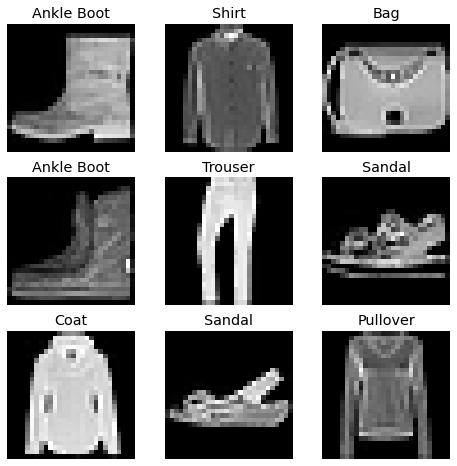

In [32]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

I found it a bit hard to extract the data for the images, stored as it was together with the labels. Here you can see me getting the image and the label.

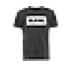

In [33]:
show_image(training_data[1][0][0]);

In [34]:
training_data[1][1]

0

There are 60,000 items in this training dataset, and 10 categories, so it makes sense that the set of images for the two categories I extracted would be 6000 each.

In [35]:
training_dresses = [item[0][0] for item in training_data if item[1] == 3]
training_pullovers = [item[0][0] for item in training_data if item[1] == 2]

len(training_dresses), len(training_pullovers)

(6000, 6000)

In [36]:
training_dresses_tensor = torch.stack(training_dresses)
training_pullovers_tensor = torch.stack(training_pullovers)

In [37]:
training_dresses_tensor.shape

torch.Size([6000, 28, 28])

## Calculate the mean image for a dress and a pullover

In [38]:
mean_training_dress = training_dresses_tensor.mean(0)
mean_training_pullover = training_pullovers_tensor.mean(0)

In [39]:
mean_training_dress.shape

torch.Size([28, 28])

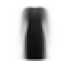

In [40]:
show_image(mean_training_dress);

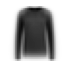

In [41]:
show_image(mean_training_pullover);

I chose the two because I wondered whether there might be a decent amount of crossover between the two items. You can see even in the 'mean' / average versions of the items that they look fairly similar.

## Assemble the validation data

In [42]:
test_dresses = [item[0][0] for item in test_data if item[1] == 3]
test_pullovers = [item[0][0] for item in test_data if item[1] == 2]

len(test_dresses), len(test_pullovers)

(1000, 1000)

In [43]:
test_dresses_tensor = torch.stack(test_dresses)
test_pullovers_tensor = torch.stack(test_pullovers)

In [44]:
test_dresses_tensor.shape

torch.Size([1000, 28, 28])

I also extract a single dress and a single pullover to check the loss in the next section.

In [45]:
sample_test_dress = test_dresses_tensor[0]
sample_test_pullover = test_pullovers_tensor[10]

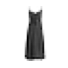

In [46]:
show_image(sample_test_dress);

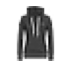

In [47]:
show_image(sample_test_pullover);

## Calculate the loss comparing a random pullover with validation data

In [48]:
def get_l1_norm(tensor1, tensor2):
    return (tensor1 - tensor2).abs().mean()

def get_l2_norm(tensor1, tensor2):
    return ((tensor1 - tensor2)**2).mean().sqrt()

In [49]:
l1_norm_distance_dress = get_l1_norm(sample_test_dress, mean_training_dress)
l2_norm_distance_dress = get_l2_norm(sample_test_dress, mean_training_dress)

l1_norm_distance_dress, l2_norm_distance_dress

(tensor(0.1134), tensor(0.1766))

In [50]:
l1_norm_distance_pullover = get_l1_norm(sample_test_pullover, mean_training_pullover)
l2_norm_distance_pullover = get_l2_norm(sample_test_pullover, mean_training_pullover)

l1_norm_distance_pullover, l2_norm_distance_pullover

(tensor(0.1713), tensor(0.2220))

The differences from our `sample_test_dress` to the `mean_training_dress` is less than the differences between our `sample_test_dress` and the `mean_training_pullover`. This totally makes sense and is what we were expecting!

In [51]:
assert l1_norm_distance_dress < l1_norm_distance_pullover
assert l2_norm_distance_dress < l2_norm_distance_pullover

## Using broadcasting to check our predictions on our validation data

This function returns the L1 norm loss when calculated between two tensors. Because of the final tuple passed into `.mean()` (i.e. `(-1, -2)`), we can actually use this function to calculate the distance between a single image as compared to a full rank-3 tensor.

In [52]:
def fashion_mnist_distance(tensor1, tensor2):
    return (tensor1 - tensor2).abs().mean((-1, -2))

In [53]:
fashion_mnist_distance(sample_test_dress, mean_training_dress)

tensor(0.1134)

In [54]:
fashion_mnist_distance(sample_test_dress, mean_training_pullover)

tensor(0.2864)

Again, our dress is 'closer' to the `mean_training_dress` than it is to the `mean_training_pullover`.

We can now create a function that predicts (by way of calculating and comparing these two losses) whether an item is a dress or not.

In [55]:
def is_dress(x):
    return fashion_mnist_distance(x, mean_training_dress) < fashion_mnist_distance(x, mean_training_pullover)

In [56]:
is_dress(sample_test_dress)

tensor(True)

In [57]:
is_dress(sample_test_pullover)

tensor(False)

...as expected...

Finally, we can get an overall sense of how well our prediction function is on average. We get it to calculate predictions for the entire test dataset and average them out.

In [58]:
dress_accuracy = is_dress(test_dresses_tensor).float().mean()

In [59]:
pullover_accuracy = 1 - is_dress(test_pullovers_tensor).float().mean()

In [60]:
combined_accuracy = (dress_accuracy + pullover_accuracy) / 2
combined_accuracy, dress_accuracy, pullover_accuracy

(tensor(0.9175), tensor(0.9730), tensor(0.8620))

Overall, I think 91% accuracy using this fairly simple mechanism isn't too bad at all! That said, in the fastai course we're here to learn about deep learning, so in the next post I will dive more into the beginnings of a more advanced approach to making the same calculation.